# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

df1['domain'], df2['domain'] = 1, 2

In [38]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=0)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=0)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# Join data in both domains for trating them jointly (Augmentation)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)
# df3_train, _ = RandomUnderSampler().fit_resample(df3_train, df3_train['label'])

In [39]:
# Dev set
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)

# Transform numbers to strings to treat them as tokens
txt1 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df1_train['text']]
txt2 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df2_train['text']]
aug_txt = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']]

# Train sets
x_tr1, y_tr1 = txt1, df1_train['label']
x_tr2, y_tr2 = txt2, df2_train['label']
# Train sets (Data Augmentation)
x_tr_aug, y_train_aug = aug_txt, df3_train['label']
# Dev set
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

In [40]:
df3_train['domain'].value_counts()

domain
2    12000
1     4000
Name: count, dtype: int64

In [41]:
# Print classes proportion
print(round(df3_train['label'].value_counts()/len(df3_train['label']),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 2. Encoding

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tokens encoding to sparce matrix (Countv)
Cvec1 = CountVectorizer()
Cvec2 = CountVectorizer()
Cvec3 = CountVectorizer()

# Vectorize training sets
x_train1_c = Cvec1.fit_transform(x_tr1)
x_train2_c = Cvec2.fit_transform(x_tr2)
x_train_aug_c = Cvec3.fit_transform(x_tr_aug)

# Vectorize development sets
x_dev1_c = Cvec1.transform(x_dev)
x_dev2_c = Cvec2.transform(x_dev)
x_dev_aug_c = Cvec3.transform(x_dev)

In [47]:
# Tokens encoding to sparce matrix (Tfid)
Tvec1 = TfidfVectorizer()
Tvec2 = TfidfVectorizer()
Tvec3 = TfidfVectorizer(ngram_range=(1,5))

# Vectorize training sets
x_train1_t = Tvec1.fit_transform(x_tr1)
x_train2_t = Tvec2.fit_transform(x_tr2)
x_train_aug_t = Tvec3.fit_transform(x_tr_aug)

# Vectorize development sets
x_dev1_t = Tvec1.transform(x_dev)
x_dev2_t = Tvec2.transform(x_dev)
x_dev_aug_t = Tvec3.transform(x_dev)

# 3. Train Logistic Model

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
# "default"

# Train models

# Domain 1 models
cl_1_c = LogisticRegression().fit(x_train1_c, y_tr1)
cl_1_t = LogisticRegression().fit(x_train1_t, y_tr1)

# Domain 2 models
cl_2_c = LogisticRegression().fit(x_train2_t, y_tr2)
cl_2_t = LogisticRegression().fit(x_train2_c, y_tr2)

# augmented data (Both domains)
cl_aug_c = LogisticRegression().fit(x_train_aug_c, y_train_aug)
cl_aug_t = LogisticRegression().fit(x_train_aug_t, y_train_aug)
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_train_aug_c, y_train_aug)
cl_aug_t_w = LogisticRegression(class_weight="balanced").fit(x_train_aug_t, y_train_aug)

In [49]:
# Majority voting scores
def MV_pred(cl1, df1, cl2, df2):
    return np.round((cl1.predict_proba(df1).T[1] + cl2.predict_proba(df2).T[1])/2)

mv_pred_c_ts = MV_pred(cl_1_c, x_dev1_c, cl_2_c, x_dev2_c)
mv_pred_t_ts = MV_pred(cl_1_t, x_dev1_t, cl_2_t, x_dev2_t)

mv_sc_c_ts = sum([mv_pred_c_ts[i] == y_dev[i] for i, j in enumerate(y_dev)])/len(y_dev)
mv_sc_t_ts = sum([mv_pred_t_ts[i] == y_dev[i] for i, j in enumerate(y_dev)])/len(y_dev)

# Data augmentation scores
sc_aug_c_tr, sc_aug_c_ts = cl_aug_c.score(x_train_aug_c, y_train_aug), cl_aug_c.score(x_dev_aug_c, y_dev)
sc_aug_t_tr, sc_aug_t_ts = cl_aug_t.score(x_train_aug_t, y_train_aug), cl_aug_t.score(x_dev_aug_t, y_dev)
sc_aug_c_w_tr, sc_aug_c_w_ts = cl_aug_c_w.score(x_train_aug_c, y_train_aug), cl_aug_c_w.score(x_dev_aug_c, y_dev)
sc_aug_t_w_tr, sc_aug_t_w_ts = cl_aug_t_w.score(x_train_aug_t, y_train_aug), cl_aug_t_w.score(x_dev_aug_t, y_dev)
# F1 scores
f1_aug_c_tr, f1_aug_c_ts = f1_score(y_train_aug, cl_aug_c.predict(x_train_aug_c)), f1_score(y_dev, cl_aug_c.predict(x_dev_aug_c))
f1_aug_t_tr, f1_aug_t_ts = f1_score(y_train_aug, cl_aug_t.predict(x_train_aug_t)), f1_score(y_dev, cl_aug_t.predict(x_dev_aug_t))
f1_aug_c_w_tr, f1_aug_c_w_ts = f1_score(y_train_aug, cl_aug_c_w.predict(x_train_aug_c)), f1_score(y_dev, cl_aug_c_w.predict(x_dev_aug_c))
f1_aug_t_w_tr, f1_aug_t_w_ts = f1_score(y_train_aug, cl_aug_t_w.predict(x_train_aug_t)), f1_score(y_dev, cl_aug_t_w.predict(x_dev_aug_t))

# Print scores
print(f'Model -MV using  Cvec:\t\t\t\t\tval_acc: {mv_sc_c_ts:.3f}')
print(f'Model -DA using  Cvec:\t\ttr_acc: {sc_aug_c_tr:.3f}\tval_acc: {sc_aug_c_ts:.3f}\ttr_F1" {f1_aug_c_tr:.3f}\tts_F1" {f1_aug_c_ts:.3f}')
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\ttr_F1" {f1_aug_t_tr:.3f}\tts_F1" {f1_aug_t_ts:.3f}')
print()
print(f'Model -MV using  Tvec:\t\t\t\t\tvalid_acc: {mv_sc_t_ts:.3f}')
print(f'Model -DA using  Tvec:\t\ttr_acc: {sc_aug_t_tr:.3f}\tval_acc: {sc_aug_t_ts:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}')
print(f'Model -DA using  Tvec-w:\ttr_acc: {sc_aug_t_w_tr:.3f}\tval_acc: {sc_aug_t_w_ts:.3f}\ttr_F1" {f1_aug_t_w_tr:.3f}\tts_F1" {f1_aug_t_w_ts:.3f}')

Model -MV using  Cvec:					val_acc: 0.633
Model -DA using  Cvec:		tr_acc: 0.994	val_acc: 0.674	tr_F1" 0.983	ts_F1" 0.590
Model -DA using  Cvec-w:	tr_acc: 0.988	val_acc: 0.697	tr_F1" 0.556	ts_F1" 0.474

Model -MV using  Tvec:					valid_acc: 0.500
Model -DA using  Tvec:		tr_acc: 0.882	val_acc: 0.619	tr_F1" 0.968	ts_F1" 0.653
Model -DA using  Tvec-w:	tr_acc: 0.921	val_acc: 0.532	tr_F1" 0.825	ts_F1" 0.515


              precision    recall  f1-score   support

           0       0.58      0.89      0.70      1000
           1       0.76      0.34      0.47      1000

    accuracy                           0.62      2000
   macro avg       0.67      0.62      0.59      2000
weighted avg       0.67      0.62      0.59      2000



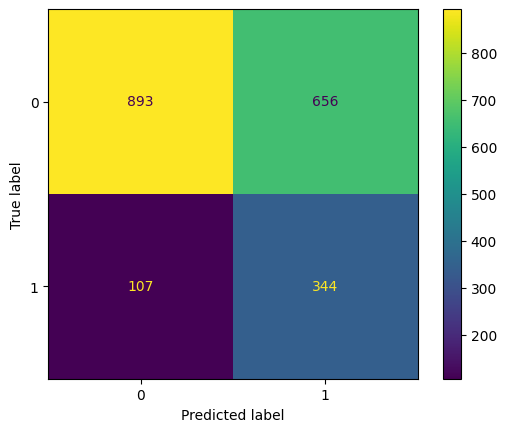

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

C = confusion_matrix(cl_aug_t.predict(x_dev_aug_t), y_dev)
cm = ConfusionMatrixDisplay(confusion_matrix=C)
cm.plot()
print(classification_report(y_dev, cl_aug_t.predict(x_dev_aug_t)))

> The majority voting technique has worse performance than Data Augmentation in all the encoders applied. Thus, for the next steps this is the dataset to use.

## sklearn.ensemble.RandomForestClassifier

In [106]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(x_train_aug_t, y_train_aug)


print(clf.score(x_dev_aug_t, y_dev))
f1_score(y_dev, clf.predict(x_dev_aug_t))

0.7635


0.7373681288173237

In [116]:
from sklearn.model_selection import RandomizedSearchCV
# Create the random grid
random_grid = {'bootstrap': [True],
        'max_depth': [10, 50, 100],
        'min_samples_leaf': [1, 4],
        'min_samples_split': [2, 10],
        'n_estimators': [200, 500, 1000]}


rf = RandomForestClassifier()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_aug_t, y_train_aug)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.579 total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.671 total time=   8.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.673 total time=   9.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.564 total time=   7.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.660 total time=   7.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.580 total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.667 total time=  20.3

KeyboardInterrupt: 

In [117]:
from sklearn.metrics import classification_report 
grid_predictions = rf_random.predict(x_dev_aug_t) 
  
# print classification report 
print(classification_report(y_dev, grid_predictions)) 

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Predict on sample data

In [23]:
# Predict on sample data
# Read data
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in pd.read_json('../Data/test_data.json', lines=True)['text']]
# Encoding
x_test = Tvec3.transform(test)
# Predict
x_pred = cl_aug_t_w.predict(x_test)
# Create DF
df = pd.DataFrame([[i,j] for i,j in enumerate(x_pred)], columns=['id', 'class'])
# Save file
df.to_csv('../Data/predictions.csv', index=False)

# 3. Train SVM model